In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

***

**데이터 준비**

In [2]:
# 데이터 불러오기
FILE_PATH = os.getenv("HOME") + "/aiffel/transformer_chatbot/data/ChatbotData.csv"
DATA = pd.read_csv(FILE_PATH)
DATA

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


* [songys/Chatbot_data](https://github.com/songys/Chatbot_data)
* 다음 카페 "사랑보다 아름다운 실연"을 참고하여 songys님께서 직접 제작한 데이터 
* 라벨 0, 1, 2는 각각 일상, 긍정, 부정

In [3]:
DATA['label'].unique()

array([0, 1, 2])

In [4]:
DATA[DATA['label'] == 0] # 일상

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
5285,힘내야지,응원합니다!,0
5286,힘든 것 좀 끝났으면,다 지나갈 거예요.,0
5287,힘든 시기가 지나갔으면,다 지나갈 거예요.,0
5288,힘든 데도 날 도와준 사람,잊지말고 보답하세요.,0


In [5]:
DATA[DATA['label'] == 1] # 부정

,Q,A,label
5290,1000일 만난 여자친구와 이별,더 오래 만날 사람 만날 거예요.,1
5291,10년 연애. 헤어졌습니다.,더 공허함이 크시겠네요.,1
5292,10년 연애사 되돌아보니 다 부질없네,더 좋은 사람 만나실 거예요.,1
5293,10년 연예의끝,더 마음이 허하겠어요.,1
5294,10년만나다 헤어지네,충분히 슬퍼하고 충분히 아파하다가 이겨내세요.,1
...,...,...,...
8855,힘듭니다.,어떤 말도 위로가 되지 않겠지만 힘내세요.,1
8856,힘이 될런지 모르겠지만,어떤 말도 위로가 되지 않겠지만 힘내세요.,1
8857,힘이 드네,어떤 말도 위로가 되지 않겠지만 힘내세요.,1
8858,힘이 없어,힘내세요!,1


In [6]:
DATA[DATA['label'] == 2] # 긍정

,Q,A,label
8860,짝사랑만큼 고통스러운 건 없겠지.,짝사랑 만큼 감정소모가 큰 건 없을 거예요.,2
8861,1년 넘게 만났는데 지금도 불타올라,정열적인 사랑을 하고 있나봐요.,2
8862,1년 동거 중인데 계속 좋아,서로 깊게 알게되면서 더 좋아졌나봅니다.,2
8863,1년 동거하고 결혼했어,축하합니다!,2
8864,1년 만났는데도 그 사람에 대해 잘 모르겠어,더 만나보세요.,2
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [7]:
# DataFrame -> list
questions = DATA['Q'].tolist()
answers = DATA['A'].tolist()

In [8]:
## 데이터 전처리
def preprocess(sentence):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # 마침표 사이에 공백 추가
    sentence = re.sub(r"([' '])+", " ", sentence) # 둘 이상의 공백을 하나의 공백으로
    sentence = sentence.strip() # 데이터 앞뒤 공백 제거
    
    return sentence

In [9]:
# 데이터 전처리
questions = [preprocess(sentence) for sentence in questions]
answers = [preprocess(sentence) for sentence in answers]

In [10]:
# 데이터 크기
print('length of questions :', len(questions))
print('length of answers :', len(answers))

length of questions : 11823
length of answers : 11823


In [11]:
# 전처리한 데이터 예시
print('question example (after preprocess) :', questions[32])
print('answer example (after preprocess) :', answers[32])

question example (after preprocess) : 가족들이랑 어디 가지 ?
answer example (after preprocess) : 온 가족이 모두 마음에 드는 곳으로 가보세요 .


In [12]:
# 토크나이저 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [13]:
# 시작 토큰과 종료 토큰 생성
VOCAB_SIZE = tokenizer.vocab_size + 2
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print('START_TOKEN index :' ,[tokenizer.vocab_size])
print('END_TOKE index :' ,[tokenizer.vocab_size + 1])

START_TOKEN index : [8173]
END_TOKE index : [8174]


In [14]:
# 인코딩한 데이터 예시
print('question example (encode) :', tokenizer.encode(questions[32]))
print('answer example (encode) :', tokenizer.encode(answers[32]))

question example (encode) : [7876, 1156, 1055, 2]
answer example (encode) : [1087, 3174, 591, 264, 877, 621, 287, 1]


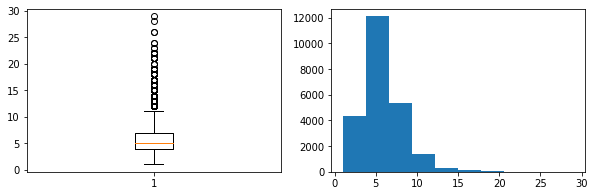

In [15]:
# 토큰의 최대 길이 설정을 위한 시각화

qna = questions + answers
len_tokens = [len(tokenizer.encode(s)) for s in qna]

plt.figure(figsize = (10, 3))
plt.subplot(121)
plt.boxplot(len_tokens)
plt.subplot(122)
plt.hist(len_tokens)
plt.show()

* 플롯을 통해 대부분의 데이터가 길이 20 이내라는 점을 알 수 있음
* 토큰의 최대 길이를 20으로 설정

In [16]:
MAX_LENGTH = 20

## 데이터 토큰화
def tokenize(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for i, o in zip(inputs, outputs):
        i = START_TOKEN + tokenizer.encode(i) + END_TOKEN # 입력 데이터에 시작/종료 토큰 추가
        o = START_TOKEN + tokenizer.encode(o) + END_TOKEN # 출력 데이터에 시작/종료 토큰 추가
    
        # 최대 길이 제한
        if len(i) <= MAX_LENGTH and len(o) <= MAX_LENGTH:
            tokenized_inputs.append(i)
            tokenized_outputs.append(o)
    
    # 패딩 추가
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen = MAX_LENGTH, padding = 'post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen = MAX_LENGTH, padding = 'post')
    
    return tokenized_inputs, tokenized_outputs

In [17]:
# 데이터 토큰화
questions, answers = tokenize(questions, answers)

In [18]:
# 데이터셋
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices(({'inputs': questions, 'decoder_inputs': answers[:, :-1]}, 
                                              {'outputs': answers[:, 1:]}))
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

---

**모델링**

Positional Encoding

* 문장의 위치(position) 정보 벡터를 인코딩합니다.

* 수식

    $PE(pos,$ <span style = "color:blue">$2i$</span>$) = sin(pos/10000^{\frac{2i}{dmodel}})$ <br/>
    $PE(pos,$ <span style = "color:blue">$2i+1$</span>$) = cos(pos/10000^{\frac{2i}{dmodel}})$

In [19]:
class PositionalEncoding(tf.keras.layers.Layer): # PositionalEncoding(row, col)
    
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
    
    def get_angles(self, position, i, d_model): # pos/10000^(2i/d_model)
        numerator = 2 * (i // 2) # 2i
        denominator = tf.cast(d_model, tf.float32) # d_model
        angles = 1 / tf.pow(1e+4, numerator / denominator) # 10000^(2i/d_model)
        return position * angles # pos/10000^(2i/d_model)
    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position = tf.range(position, dtype = tf.float32)[:, tf.newaxis],
            i = tf.range(d_model, dtype = tf.float32)[tf.newaxis, :],
            d_model = d_model
        )
        
        sin = tf.math.sin(angle_rads[:, 0::2]) # PE(pos, 2i)
        cos = tf.math.cos(angle_rads[:, 1::2]) # PE(pos, 2i+1)
        
        pos_encoding = tf.stack([sin, cos], axis = 0)
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        pos_encoding = pos_encoding[tf.newaxis, ...]
        
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

Scaled Dot Product Attention

* 단어 사이의 유사도를 구해 학습 및 예측에 활용합니다.
* 유사도를 스케일드 닷 프로덕트 어텐션을 통해 구합니다.

* 수식

    $Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$ <br/>
    $Q$는 쿼리(문장), $K$는 키(단어), $V$는 값(유사도)

In [20]:
def scaled_dot_product_attention(query, key, value, mask):
    numerator = tf.matmul(query, key, transpose_b = True) # Q(K^T)
    denominator = tf.math.sqrt(tf.cast(tf.shape(key)[-1], tf.float32)) # root(d_k)
    logits = numerator / denominator # Q(K^T) / root(d_k)
    
    if mask is not None:
        logits += (mask * -1e+9) # softmax(-infty) = 0
    
    attention_weights = tf.nn.softmax(logits, axis = -1) # softmax(Q(K^T) / root(d_k))
    
    attention_value = tf.matmul(attention_weights, value) # softmax(Q(K^T) / root(d_k))V
    
    return attention_value

Multi Head Attention

* 어텐션 병렬 배치

    $d_{model} = d_v * num_{heads}$

In [21]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name = "multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name = name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0, "not available num_heads"
        
        self.query_dense = tf.keras.layers.Dense(units = d_model)
        self.key_dense = tf.keras.layers.Dense(units = d_model)
        self.value_dense = tf.keras.layers.Dense(units = d_model)
        self.dense = tf.keras.layers.Dense(units = d_model)
        
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape = (batch_size, -1, self.num_heads, self.d_model // self.num_heads)
        )
        return tf.transpose(inputs, perm = [0, 2, 1, 3])
    
    def call(self, inputs):
        query = inputs['query']
        key = inputs['key']
        value = inputs['value']
        mask = inputs['mask']
        
        batch_size = tf.shape(query)[0]
        
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        attention = scaled_dot_product_attention(query, key, value, mask)
        attention = tf.transpose(attention, perm = [0, 2, 1, 3])
        attention = tf.reshape(attention, (batch_size, -1, self.d_model))
        attention = self.dense(attention)
        
        return attention

Masking

* 일부 값을 연산에 사용하지 않습니다.

In [22]:
## padding masking
def mask_pad(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32) # 1 if x = 0 else 0
    return mask[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, length of sequence)

## look-ahead masking
def mask_back(x):
    l = tf.shape(x)[1]
    mask = 1 - tf.linalg.band_part(tf.ones((l, l)), -1, 0)
    pad = mask_pad(x)
    return tf.maximum(mask, pad)

Encoder

* 입력 문장을 받아 정보를 얻고, 디코더에 전달하는 인코더(입력 처리)입니다.
* 인코더 셀프 언텐션(입력 단어 - 입력 단어의 유사도)층과 완전 연결층이 포함됩니다.

In [23]:
def encoder_layer(units, d_model, num_heads, dropout, name = "encoder_layer"):
    
    # 0. input (+ padding mask)
    inputs = tf.keras.Input(shape = (None, d_model), name = "inputs")
    pad = tf.keras.Input(shape = (1, 1, None), name = "pad")
    
    # 1. encoder self attention (+ dropout & layer normalization)
    attention = MultiHeadAttention(d_model, num_heads, name = "attention")({
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': pad
    })
    attention = tf.keras.layers.Dropout(rate = dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(inputs + attention)
    
    # 2. fully connected (+ dropout & layer normalization)
    outputs = tf.keras.layers.Dense(units = units, activation = 'relu')(attention)
    outputs = tf.keras.layers.Dense(units = d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate = dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(attention + outputs)
    
    return tf.keras.Model(inputs = [inputs, pad], outputs = outputs, name = name)


def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name = "encoder"):
    
    # input (+ padding mask)
    inputs = tf.keras.Input(shape = (None, ), name = "inputs")
    pad = tf.keras.Input(shape = (1, 1, None), name = "pad")
    
    # embedding (+ positional encoding)
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    embeddings = tf.keras.layers.Dropout(rate = dropout)(embeddings)
    
    # encoder_layer * num_layers
    outputs = embeddings
    for n in range(num_layers):
        outputs = encoder_layer(units = units, d_model = d_model, num_heads = num_heads, 
                                dropout = dropout, name = f"encoder_layer_{n}")([outputs, pad])
    
    return tf.keras.Model(inputs = [inputs, pad], outputs = outputs, name = name)

Decoder

* 인코더에서 정보를 받아 문장을 생성하는 디코더(출력)입니다.
* 디코더 셀프 어텐션(출력 단어 - 출력 단어의 유사도)층과 인코더 디코더 어텐션(입력 단어 - 출력 단어의 유사도)층, 그리고 완전연결층이 포함됩니다.

In [24]:
def decoder_layer(units, d_model, num_heads, dropout, name = "decoder_layer"):
    
    # 0. input (+ encoder outputs & masking)
    inputs = tf.keras.Input(shape = (None, d_model), name = "inputs")
    encoder = tf.keras.Input(shape = (None, d_model), name = "encoder")
    mask = tf.keras.Input(shape = (1, None, None), name = "mask")
    pad = tf.keras.Input(shape = (1, 1, None), name = "pad")
    
    # 1. decoder self attention (+ layer normalization)
    attention1 = MultiHeadAttention(d_model, num_heads, name = "first_attention")({
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': mask
    })
    attention1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(inputs + attention1)
    
    # 2. encoder - decoder attention (+ dropout & layer normalization)
    attention2 = MultiHeadAttention(d_model, num_heads, name = "second_attention")({
        'query': attention1,
        'key': encoder,
        'value': encoder,
        'mask': pad
    })
    attention2 = tf.keras.layers.Dropout(rate = dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(attention1 + attention2)
    
    # 3. fully connected (+ dropout & layer normalization)
    outputs = tf.keras.layers.Dense(units = units, activation = 'relu')(attention2)
    outputs = tf.keras.layers.Dense(units = d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate = dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(attention2 + outputs)
    
    return tf.keras.Model(inputs = [inputs, encoder, mask, pad], outputs = outputs, name = name)


def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name = 'decoder'):
    
    # input (+ encoder & masking)
    inputs = tf.keras.Input(shape = (None, ), name = "inputs")
    encoder_outputs = tf.keras.Input(shape = (None, d_model), name = "encoder_output")
    
    mask = tf.keras.Input(shape = (1, None, None), name = "mask")
    pad = tf.keras.Input(shape = (1, 1, None), name = "pad")
    
    # embedding (+ positional encoding)
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    embeddings = tf.keras.layers.Dropout(rate = dropout)(embeddings)
    
    # decoder_layer * num_layers
    outputs = embeddings
    for n in range(num_layers):
        outputs = decoder_layer(units = units, d_model = d_model, num_heads = num_heads, 
                                dropout = dropout, name = f"decoder_layer_{n}")(inputs = [outputs, encoder_outputs, mask, pad])
    
    return tf.keras.Model(inputs = [inputs, encoder_outputs, mask, pad], outputs = outputs, name = name)

Transformer

* 인코더와 디코더를 결합한 최종 모델입니다.

In [25]:
def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout, name = "transfomer"):
    
    # input
    inputs = tf.keras.Input(shape = (None, ), name = "inputs")
    decoder_inputs = tf.keras.Input(shape = (None, ), name = "decoder_inputs")
    
    # masking
    encoder_pad = tf.keras.layers.Lambda(mask_pad, output_shape = (1, 1, None), name = 'encoder_pad')(inputs)
    decoder_pad = tf.keras.layers.Lambda(mask_pad, output_shape = (1, 1, None), name = 'decoder_pad')(inputs)
    decoder_mask = tf.keras.layers.Lambda(mask_back, output_shape = (1, None, None), name = 'decoder_mask')(decoder_inputs)
    
    # encoder
    encoder_outputs = encoder(vocab_size = vocab_size, num_layers = num_layers, 
                              units = units, d_model = d_model, num_heads = num_heads, 
                              dropout = dropout)(inputs = [inputs, encoder_pad])
    
    # decoder
    decoder_outputs = decoder(vocab_size = vocab_size, num_layers = num_layers, 
                              units = units, d_model = d_model, num_heads = num_heads, 
                              dropout = dropout)(inputs = [decoder_inputs, encoder_outputs, decoder_mask, decoder_pad])
    
    # output (fully connected)
    outputs = tf.keras.layers.Dense(units = vocab_size, name = "outputs")(decoder_outputs)
    
    return tf.keras.Model(inputs = [inputs, decoder_inputs], outputs = outputs, name = name)

---

**모델 훈련**

In [26]:
# 모델 생성

tf.keras.backend.clear_session()

NUM_LAYERS = 2
UNITS = 512
D_MODEL = 256
NUM_HEADS = 8
DROPOUT = 0.1

model = transformer(vocab_size = VOCAB_SIZE, num_layers = NUM_LAYERS, units = UNITS, 
                    d_model = D_MODEL, num_heads = NUM_HEADS, dropout = DROPOUT)

model.summary()

Model: "transfomer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_pad (Lambda)            (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3147008     inputs[0][0]                     
                                                                 encoder_pad[0][0]       

In [27]:
## 손실 함수
def loss_function(target, pred):
    target = tf.reshape(target, shape = (-1, MAX_LENGTH - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')(target, pred)
    mask = tf.cast(tf.not_equal(target, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    
    return tf.reduce_mean(loss)

In [28]:
## learning reate 최적화
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps = 4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
    
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [29]:
# 모델 컴파일

learning_rate = CustomSchedule(D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.98, epsilon = 1e-9)

model.compile(optimizer = optimizer, loss = loss_function, metrics = ['accuracy'])

In [30]:
# 모델 훈련

EPOCHS = 20
history = model.fit(dataset, epochs = EPOCHS, verbose =1)

Epoch 1/20
185/185 [==============================] - 13s 37ms/step - loss: 2.9654 - accuracy: 0.0564
Epoch 2/20
185/185 [==============================] - 7s 37ms/step - loss: 2.4038 - accuracy: 0.1017
Epoch 3/20
185/185 [==============================] - 7s 38ms/step - loss: 2.0392 - accuracy: 0.1042
Epoch 4/20
185/185 [==============================] - 7s 37ms/step - loss: 1.8859 - accuracy: 0.1118
Epoch 5/20
185/185 [==============================] - 7s 37ms/step - loss: 1.7668 - accuracy: 0.1186
Epoch 6/20
185/185 [==============================] - 7s 37ms/step - loss: 1.6469 - accuracy: 0.1271
Epoch 7/20
185/185 [==============================] - 7s 37ms/step - loss: 1.5125 - accuracy: 0.1388
Epoch 8/20
185/185 [==============================] - 7s 37ms/step - loss: 1.3650 - accuracy: 0.1548
Epoch 9/20
185/185 [==============================] - 7s 37ms/step - loss: 1.2045 - accuracy: 0.1722
Epoch 10/20
185/185 [==============================] - 7s 37ms/step - loss: 1.0378 - accur

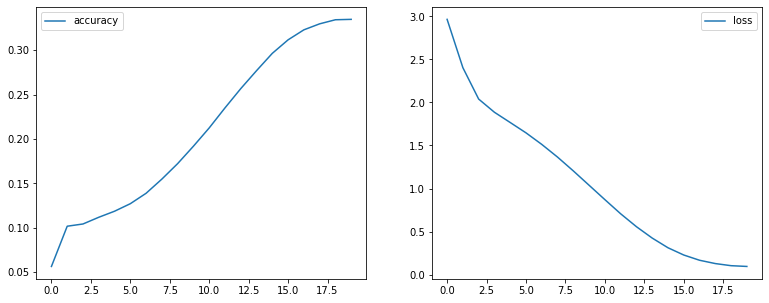

In [31]:
# 훈련 결과 시각화
plt.figure(figsize = (13, 5))

# 정확도
plt.subplot(121)
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.legend()

# 손실
plt.subplot(122)
plt.plot(history.history['loss'], label = 'loss')
plt.legend()

plt.show()

***

**모델 예측**

In [32]:
## 입력 데이터에 대한 예측
def inference(sentence):
    sentence = preprocess(sentence)
    
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis = 0)
    outputs = tf.expand_dims(START_TOKEN, 0)
    
    for i in range(MAX_LENGTH):
        predictions = model(inputs = [sentence, outputs], training = False)
        predictions = predictions[:, -1:, :]
        pred_idx = tf.cast(tf.argmax(predictions, axis = -1), tf.int32)
        if tf.equal(pred_idx, END_TOKEN[0]):
            break
        
        outputs = tf.concat([outputs, pred_idx], axis = -1)
    
    return tf.squeeze(outputs, axis = 0)

In [33]:
## 예측에 대한 문장 생성
def generator(sentence):
    prediction = inference(sentence)
    prediction = tokenizer.decode([pred for pred in prediction if pred < tokenizer.vocab_size])
    
    print("input :", sentence)
    print("output :", prediction)
    
    return prediction

In [34]:
generator("안녕하세요")

input : 안녕하세요
output : 안녕하세요 .


'안녕하세요 .'

In [35]:
generator("취업하고싶어요")

input : 취업하고싶어요
output : 네 말씀해주세요 .


'네 말씀해주세요 .'

In [36]:
generator("성공할 수 있을까요?")

input : 성공할 수 있을까요?
output : 인내할 수 있는 사람이라면 무엇이든 손에 넣을 수 있을 거예요 .


'인내할 수 있는 사람이라면 무엇이든 손에 넣을 수 있을 거예요 .'

---

**프로젝트 한계**

* 입력 문장과 유사한 Question 데이터를 찾아서, 해당 Answer 데이터를 그대로 출력하고 있습니다.

In [37]:
generator("안녕하세요")
DATA[2949:2953]

input : 안녕하세요
output : 안녕하세요 .


,Q,A,label
2949,안녕,안녕하세요.,0
2950,안녕안녕,안녕하세요.,0
2951,안녕하세요,안녕하세요.,0
2952,안뇽,안녕하세요.,0


In [68]:
generator("날씨가 추워요")
DATA[699:700]

input : 날씨가 추워요
output : 집밖에 나가기가 힘들것 같아요 .


,Q,A,label
699,날씨가 너무 추워,집밖에 나가기가 힘들것 같아요.,0


In [65]:
generator("성공하고 싶어요")
DATA.loc[[11343, 11475]]

input : 성공하고 싶어요
output : 큰 결심이네요 . 꼭 성공할 거예요 .


,Q,A,label
11343,짝남 보란듯이 성공하고 싶어요.,큰 결심이네요. 꼭 성공할 거예요.,2
11475,짝녀 보란 듯이 성공하고 싶습니다.,큰 결심이네요. 꼭 성공할 거예요.,2


---

**프로젝트 개선**

* 한국어 자연어 분석은 형태소 분석기를 사용하여 토큰나이징 하는 것으로 알려져 있습니다.
* 앞서 사용한 subword tokenizer 대신 한국어 형태소 분석기 konlpy.tag Mecab을 사용합니다.
* subword tokenizer는 어절 분석에 있어 통계적으로 접근합니다.
* 형태소 분석기 konlpy.tag의 Mecab은 언어 문법 체계를 기반으로 접근합니다.

In [40]:
from konlpy.tag import Mecab
from collections import Counter

# 토크나이저 생성
tokenizer2 = Mecab()

# 데이터 토큰화
def tokenize2(inputs, outputs, MAX_LENGTH):
    inputs_words, outputs_words = [], []

    for i, o in zip(inputs, outputs):
        i = tokenizer2.morphs(i) # 형태소 분리
        o = tokenizer2.morphs(o) # 형태소 분리

        # 최대 길이 제한
        if len(i) <= MAX_LENGTH and len(o) <= MAX_LENGTH:
            inputs_words.append(i)
            outputs_words.append(o)
    
    # 단어 사전
    words = np.concatenate(inputs_words).tolist() + np.concatenate(outputs_words).tolist()
    words = set(words)
    vocab = ["<pad>", "<start>", "<end>"] + [word for word in words]
    vocab = {word : index for index, word in enumerate(vocab)}
    
    # word -> 정수 토큰
    def token(data):
        return [1] + [vocab[word] for word in data] + [2]
    
    
    tokenized_inputs = list(map(token, inputs_words))
    tokenized_outputs = list(map(token, outputs_words))
    
    # 패딩 추가
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen = MAX_LENGTH, padding = 'post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen = MAX_LENGTH, padding = 'post')

    return tokenized_inputs, tokenized_outputs, vocab

In [41]:
# DataFrame -> list
questions = DATA['Q'].tolist()
answers = DATA['A'].tolist()

# 데이터 토큰화
questions, answers, vocab = tokenize2(questions, answers, MAX_LENGTH)

## 데이터셋
dataset = tf.data.Dataset.from_tensor_slices(({'inputs': questions, 'decoder_inputs': answers[:, :-1]}, 
                                              {'outputs': answers[:, 1:]}))
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [42]:
# 모델 생성
model2 = transformer(vocab_size = len(vocab), num_layers = NUM_LAYERS, units = UNITS, 
                    d_model = D_MODEL, num_heads = NUM_HEADS, dropout = DROPOUT)

# 모델 컴파일
model2.compile(optimizer = optimizer, loss = loss_function, metrics = ['accuracy'])

# 모델 훈련
history2 = model2.fit(dataset, epochs = EPOCHS, verbose =1)

Epoch 1/20
183/183 [==============================] - 12s 35ms/step - loss: 2.1845 - accuracy: 0.1419
Epoch 2/20
183/183 [==============================] - 6s 35ms/step - loss: 1.5540 - accuracy: 0.2108
Epoch 3/20
183/183 [==============================] - 6s 35ms/step - loss: 1.3168 - accuracy: 0.2376
Epoch 4/20
183/183 [==============================] - 6s 35ms/step - loss: 1.1350 - accuracy: 0.2630
Epoch 5/20
183/183 [==============================] - 6s 35ms/step - loss: 0.9871 - accuracy: 0.2851
Epoch 6/20
183/183 [==============================] - 6s 35ms/step - loss: 0.8652 - accuracy: 0.3041
Epoch 7/20
183/183 [==============================] - 6s 35ms/step - loss: 0.7609 - accuracy: 0.3225
Epoch 8/20
183/183 [==============================] - 6s 35ms/step - loss: 0.6713 - accuracy: 0.3376
Epoch 9/20
183/183 [==============================] - 6s 35ms/step - loss: 0.5950 - accuracy: 0.3514
Epoch 10/20
183/183 [==============================] - 6s 35ms/step - loss: 0.5262 - accur

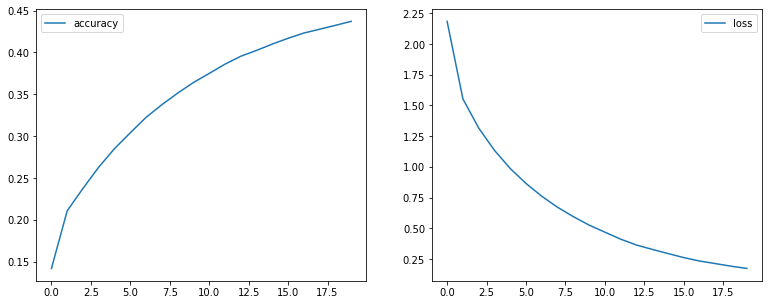

In [43]:
# 훈련 결과 시각화
plt.figure(figsize = (13, 5))

# 정확도
plt.subplot(121)
plt.plot(history2.history['accuracy'], label = 'accuracy')
plt.legend()

# 손실
plt.subplot(122)
plt.plot(history2.history['loss'], label = 'loss')
plt.legend()

plt.show()

In [44]:
# 입력 데이터에 대한 예측
def inference2(sentence, vocab):
    sentence = preprocess(sentence)
    sentence = tokenizer2.morphs(sentence)
    
    sentence = tf.expand_dims([1] + [vocab[word] if word in vocab else "" for word in sentence] + [2], axis = 0)
    outputs = tf.expand_dims([1], 0)
    
    for i in range(MAX_LENGTH):
        predictions = model2(inputs = [sentence, outputs], training = False)
        predictions = predictions[:, -1:, :]
        pred_idx = tf.cast(tf.argmax(predictions, axis = -1), tf.int32)
        if tf.equal(pred_idx, 2):
            break
        
        outputs = tf.concat([outputs, pred_idx], axis = -1)
    
    return tf.squeeze(outputs, axis = 0)

# 예측에 대한 문장 생성
def generator2(sentence, vocab = vocab):
    prediction = inference2(sentence, vocab)
    vocab = dict(map(reversed, vocab.items()))
    prediction = [vocab[int(i)] for i in prediction[1:]]
    prediction = "".join(prediction)
    
    print("input :", sentence)
    print("output :", prediction)
    
    return prediction

In [45]:
generator2("안녕하세요")

input : 안녕하세요
output : 안녕하세요.


'안녕하세요.'

In [51]:
generator2("날씨가 추워요")

input : 날씨가 추워요
output : 집에도움이될거예요.


'집에도움이될거예요.'

In [53]:
generator2("성공하고 싶어요")

input : 성공하고 싶어요
output : 성공했길바랍니다.


'성공했길바랍니다.'

---

**프로젝트 평가**

* 정확도는 형태소 분석기(konlpy.tag Mecab)를 사용했을 때가 더 높고,
* loss는 subword tokenizer를 사용했을 때 더 빨리 감소합니다.

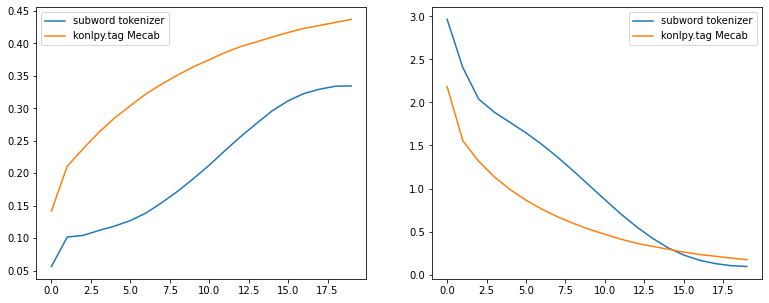

In [57]:
## 훈련 결과 시각화
plt.figure(figsize = (13, 5))

# 정확도
plt.subplot(121)
plt.plot(history.history['accuracy'], label = 'subword tokenizer') # 기존
plt.plot(history2.history['accuracy'], label = 'konlpy.tag Mecab') # 개선
plt.legend()

# 손실
plt.subplot(122)
plt.plot(history.history['loss'], label = 'subword tokenizer') # 기존
plt.plot(history2.history['loss'], label = 'konlpy.tag Mecab') # 개선
plt.legend()

plt.show()

* 앞서 subword tokenizer를 사용했을 때 입력 문장과 가장 유사한 Question의 해당 Answer를 그대로 출력하는 한계가 있었습니다.
* 형태소 분석기(konlpy.tag Mecab)를 사용했을 때 이 문제가 다소 개선됩니다.

In [78]:
## 문장 생성 비교 1 (안녕하세요)

# 기존
print("subword tokenizer")
generator("안녕하세요")
print()

# 개선
print("konlpy.tag Mecab")
generator2("안녕하세요")

# 출력한 문장과 유사한 원본 데이터
DATA[2949:2953]

subword tokenizer
input : 안녕하세요
output : 안녕하세요 .

konlpy.tag Mecab
input : 안녕하세요
output : 안녕하세요.


,Q,A,label
2949,안녕,안녕하세요.,0
2950,안녕안녕,안녕하세요.,0
2951,안녕하세요,안녕하세요.,0
2952,안뇽,안녕하세요.,0


* 형태소 분석기(konlpy.tag Mecab)를 사용한 경우 문법적으로 정확하지는 않지만, 창의적인 답변을 생성합니다.

In [71]:
## 문장 생성 비교 2 (날씨가 추워요)

# 기존
print("subword tokenizer")
generator("날씨가 추워요")
print()

# 개선
print("konlpy.tag Mecab")
generator2("날씨가 추워요")

# 출력한 문장(기존)과 유사한 원본 데이터
DATA[699:700]

subword tokenizer
input : 날씨가 추워요
output : 집밖에 나가기가 힘들것 같아요 .

konlpy.tag Mecab
input : 날씨가 추워요
output : 집에도움이될거예요.


,Q,A,label
699,날씨가 너무 추워,집밖에 나가기가 힘들것 같아요.,0


* 형태소 분석기(konlpy.tag Mecab)를 사용한 경우 입력 문장과 출력한 Answer의 원본 Question이 유사하지 않더라도 출력합니다.

In [76]:
## 문장 생성 비교 3 (성공하고 싶어요)

# 기존
print("subword tokenizer")
generator("성공하고 싶어요")
print()

# 개선
print("konlpy.tag Mecab")
generator2("성공하고 싶어요")

# 출력한 문장(기존)과 유사한 원본 데이터
DATA.loc[[11343, 11475]]

subword tokenizer
input : 성공하고 싶어요
output : 큰 결심이네요 . 꼭 성공할 거예요 .

konlpy.tag Mecab
input : 성공하고 싶어요
output : 성공했길바랍니다.


,Q,A,label
11343,짝남 보란듯이 성공하고 싶어요.,큰 결심이네요. 꼭 성공할 거예요.,2
11475,짝녀 보란 듯이 성공하고 싶습니다.,큰 결심이네요. 꼭 성공할 거예요.,2


In [75]:
# 출력한 문장(개선)과 유사한 원본 데이터
DATA[1982:1984]

,Q,A,label
1982,방탈출 게임 갔다왔어.,성공했길 바랍니다.,0
1983,방탈출 게임 했어,성공했길 바랍니다.,0
